In [3]:
import os
import gc

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

DATA_PATH = '/home/mohamed-ali/Downloads/Beijing air quality/data'
OUT_PATH = '/home/mohamed-ali/Downloads/Beijing air quality/data/'

In [2]:
data_list = []

for path in os.listdir(DATA_PATH):
    data = pd.read_csv(os.path.join(DATA_PATH, path))
    data_list.append(data)
    
data = pd.concat(data_list, axis=0)

In [5]:
pd.__version__

'1.3.4'

In [7]:
import sklearn
sklearn.__version__

'0.24.2'

In [3]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


In [4]:
data.isna().sum()

No             0
year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

<AxesSubplot:xlabel='PM2.5', ylabel='Count'>

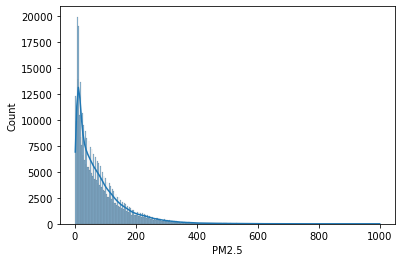

In [5]:
pm2_5 = data['PM2.5']
sns.histplot(pm2_5, kde=True)

In [6]:
# Remove outliers for the 'LIMT_BAL' variable
q1 = data['PM2.5'].quantile(0.25) # First quartile
q3 = data['PM2.5'].quantile(0.75) # Third quartile
iqr = q3 - q1 # Interquartile range
# Filter outlier observation and take their index
filtration = (data['PM2.5'] < q1 - 1.5 * iqr) | (data['PM2.5'] > q3 + 1.5 *iqr)
df_index1 = list(data.loc[filtration].index)
data = data.loc[~filtration]

In [7]:
data.shape

(401626, 18)

In [8]:
CAT_FEATURES = data.select_dtypes(include=['object']).columns.tolist()

for cat_col in CAT_FEATURES:
    encoder = LabelEncoder()
    data[cat_col] = encoder.fit_transform(data[cat_col])

data['wd'].fillna(data['wd'].mode(), inplace=True)
assert data['wd'].isna().sum() == 0
    
del encoder, CAT_FEATURES
_ = gc.collect()

In [9]:
%%time
knn_imputer = KNNImputer(n_neighbors=5)
na_columns = data.loc[:, data.isnull().any()].columns.tolist()
num_cols = [col for col in na_columns if col != 'wd']
data[num_cols] = knn_imputer.fit_transform(data[na_columns].values)

CPU times: user 20min 15s, sys: 2min 31s, total: 22min 46s
Wall time: 13min 26s


In [10]:
data.isna().sum()

No         0
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

In [14]:
data.to_csv(f'{OUT_PATH}airquality_data.csv', index=False)